# REVOIC Bulk Image Rename

Links: 

- Country specific upload: https://vendorcentral.amazon.de/imaging/upload/country
- Global upload: https://vendorcentral.amazon.de/imaging/upload

Repository: https://github.com/revoic/bulk-image-rename

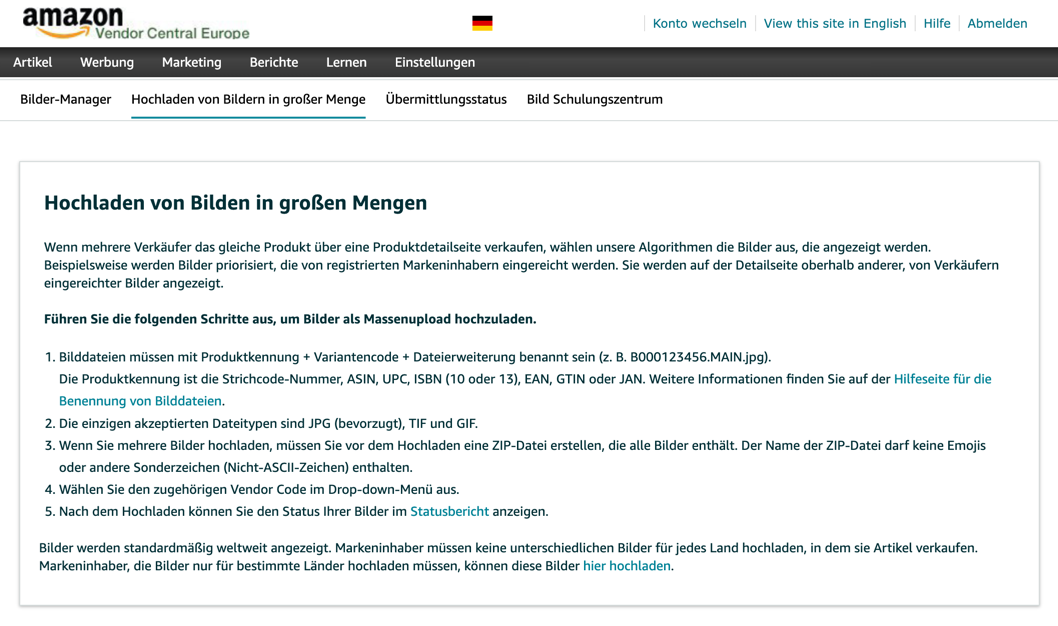

In [ ]:
import os
from os.path import exists
import pandas as pd
from pathlib import Path
import shutil
import re

In [ ]:
# This script iterates over a folder and renames all images based on a catalog file
# For 1000 images a new folder gets created

# Only supports the MAIN image at the moment

# Set the following variables

# The catalogFile should contain a column with "pattern" and the identifier to be used in the filename, e.g. the child ASIN
# Amazon also allows other identifiers, e.g. the GTIN, EAN, or UPC
catalogFile = 'catalog.xlsx' 
columnIdentifier = 'Child ASIN'
columnPattern = 'SKU'
pattern = re.compile(r'^\d{4}') # Set the regex, here: first 4 digits of filename represent the SKU

imageDir = './client_images/'
outputDir = './output'     # no trailing slash!
outputZipFilename = 'upload' # no ".zip" extension!

# Only change the code below this line if you know what your are doing :)

# Read the catalog
df = pd.read_excel(catalogFile)

df[columnPattern] = df[columnPattern].astype(str)

# Set some counters
countFound = 0
countCatalogNotFound = 0
countPatternNotFound = 0
countDuplicates = 0

filesWithNoCatalogEntry = []
filesWithNoPatternMatch = []
filesRenamed = []
filesDuplicates = []

# Iterate through all (sub)directories

for subdir, dirs, files in os.walk(imageDir):
    for file in files:
        
        if file.lower().endswith(('.jpg', '.jpeg', '.tiff', '.gif')):
            # print(os.path.join(subdir, file))
            
            # Get file extension
            file_name, file_extension = os.path.splitext(file)
            
            match = pattern.search(file)
            
            # Check, if we found the pattern
            if match:
                # print(f'Found "{match.group()}" in "{file}"')
                patternFound = match.group()

                # Lookup the product identifier in our catalog, e.g. the ASIN
                temp = pd.DataFrame()
                temp = df.loc[df[columnPattern] == str(patternFound), columnIdentifier]

                if not temp.empty:
                    productIdentifier = temp.iloc[0]
                    countFound += 1
                    
                    # Put max 1000 files in one folder and create a bucket for each, starting with 1
                    bucketNumber = str(int(countFound / 1000) + 1 )
                    outputDirBucket = outputDir + "-" + bucketNumber
                    
                    # Create the subfolder
                    Path(outputDirBucket).mkdir(parents=True, exist_ok=True)
                    
                    newFilename = os.path.join(outputDirBucket, productIdentifier + ".MAIN" + file_extension)
                    
                    if not os.path.exists(newFilename):

                        # Rename the file
                        try:
                            os.rename (os.path.join(subdir, file), newFilename)
                        except Exception as e:
                            print('Renaming the file {file} failed. See error below.')
                            print(e)
                            
                    else:
                        filesDuplicates.append(file)
                        countDuplicates += 1
                        print(f'Duplicate pattern found: {patternFound}. New filename {newFilename} already exists. File was skipped.')
                    
                    # print(f'Renamed {patternFound} to {productIdentifier}.MAIN.jpg')
                    filesRenamed.append(file)
                    
                else:
                    # We could not find an productIdentifier (e.g. the ASIN) in our catalog based on the pattern.
                    # print(f'Could not find a catalog entry for pattern {patternFound} in column {columnPattern})
                    countCatalogNotFound += 1
                    filesWithNoCatalogEntry.append(file)
            else:
                # print(f'Could not find pattern in file "{file}"')
                filesWithNoPatternMatch.append(file)
                countPatternNotFound += 1
                
                
print("----")

print(f'Count successfully renamed: {countFound}')
print(f'Count not found in catalog: {countCatalogNotFound}')
print(f'Count not found pattern in file: {countPatternNotFound}')
print(f'Duplicate patterns found: {countDuplicates}')

# Save result to Excel
dfFilesRenamed = pd.DataFrame(filesRenamed)
dfFilesWithNoCatalogEntry = pd.DataFrame(filesWithNoCatalogEntry) 
dfFilesWithNoPatternMatch = pd.DataFrame(filesWithNoPatternMatch)
dfFilesDuplicates = pd.DataFrame(filesDuplicates)

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('result.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
dfFilesRenamed.to_excel(writer, sheet_name='Renamed files', index=False)
dfFilesWithNoCatalogEntry.to_excel(writer, sheet_name='No catalog entry', index=False)
dfFilesWithNoPatternMatch.to_excel(writer, sheet_name='Pattern not found', index=False)
dfFilesDuplicates.to_excel(writer, sheet_name='Duplicate patterns', index=False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [ ]:
# Create a ZIP file for each bucket which can be uploaded to Amazon
for x in range(int(countFound / 1000) + 1):
    bucketNumber = str(x+1)
    outputDirBucket = outputDir + "-" + bucketNumber
    shutil.make_archive(outputZipFilename + str(bucketNumber).rjust(3, '0'), 'zip', outputDirBucket) # creates zipfile with right padding, e.g. "upload001.zip"